In [7]:
!pip install lifetimes

In [1]:
import datetime
import pandas as pd
import numpy as np
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from decimal import Decimal
import datetime as dt

df = pd.read_csv('P_TD_New_Elite_Data_Cohort_M3.csv')


In [2]:
# Generate summary data from transaction data
summary = summary_data_from_transaction_data(df, 'customer_id', 'order_date', 'CLV' )
summary = summary.reset_index()

In [3]:
# Fitting the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Visual representation of relationship between recency and frequency
#from lifetimes.plotting import plot_probability_alive_matrix
#fig = plt.figure(figsize=(12,8))
#plot_probability_alive_matrix(bgf)

<lifetimes.BetaGeoFitter: fitted with 1639 subjects, a: 0.00, alpha: 2268.20, b: 0.00, r: 21.75>

In [4]:
# Modeling the monetary value using Gamma-Gamma Model
ggf = GammaGammaFitter(penalizer_coef=1e-06)
return_customers_summary = summary[summary['frequency']>0]
ggf.fit(return_customers_summary['frequency'], return_customers_summary['monetary_value'])

# Calculating the conditional expected average profit for each customer per transaction
summary = summary[summary['monetary_value'] > 0]
summary['exp_avg_sales'] = ggf.conditional_expected_average_profit(summary['frequency'], summary['monetary_value'])

# Checking the expected average value and the actual average value in the data to make sure the values are good
print("Expected Average Sales: {}".format(summary['exp_avg_sales'].mean()))
print("Actual Average Sales: {}".format(summary['monetary_value'].mean()))

Expected Average Sales: 127.25673806769807
Actual Average Sales: 122.80258201701096


In [5]:
# Initialize an empty dictionary to store results
results_dict = {'Discount Rate': [], 'Months': [], 'Total CLV': []}

# Iterate over different values for the prediction period in days, months, and discount rate
for t_days in range(30, 301, 30):  # Assuming you want to iterate from 1 to 30 days
    t_months = t_days // 30  # Equivalent number of months
    for discount_rate in [0.01, 0.25]:  # Add more values if needed
        # Predict future transactions for the specified period in days
        summary['pred_num_txn_days'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t_days, summary['frequency'], summary['recency'], summary['T']), 2)

        # Predicting Customer Lifetime Value for the specified period in months
        summary['predicted_clv_months'] = ggf.customer_lifetime_value(bgf,
                                                                           summary['frequency'],
                                                                           summary['recency'],
                                                                           summary['T'],
                                                                           summary['monetary_value'],
                                                                           time=t_months,
                                                                           freq='D',
                                                                           discount_rate=discount_rate)

        summary['manual_predicted_clv_days'] = summary['pred_num_txn_days'] * summary['exp_avg_sales']
        # Store results in the dictionary
        results_dict['Discount Rate'].append(discount_rate)
        results_dict['Months'].append(t_months)
        results_dict['Total CLV'].append(summary['predicted_clv_months'].sum())

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results_dict)

# Reshape the DataFrame for better visualization
pivot_df = results_df.pivot(index='Discount Rate', columns='Months', values='Total CLV')
pivot_df.loc['Average'] = pivot_df.mean()

pivot_df_diff = pivot_df.diff(axis=1).iloc[:, 1:]

# Display the DataFrame
print(pivot_df)
print(pivot_df_diff)

Months                   1             2             3              4   \
Discount Rate                                                            
0.01           30800.546171  61296.136438  91489.790169  121384.496833   
0.25           24886.841306  44796.314351  60723.892786   73465.955535   
Average        27843.693738  53046.225395  76106.841478   97425.226184   

Months                    5              6              7              8   \
Discount Rate                                                               
0.01           150983.216302  180288.879143  209304.386906  238032.612415   
0.25            83659.605734   91814.525893   98338.462020  103557.610922   
Average        117321.411018  136051.702518  153821.424463  170795.111668   

Months                    9              10  
Discount Rate                                
0.01           266476.400046  294638.566019  
0.25           107732.930043  111073.185341  
Average        187104.665045  202855.875680  
Months       

In [6]:
pivot_df_diff = pd.DataFrame(pivot_df_diff)
pivot_df_diff

Months,2,3,4,5,6,7,8,9,10
Discount Rate,,,,,,,,,
0.01,30495.590268,30193.653731,29894.706664,29598.719469,29305.662841,29015.507763,28728.225508,28443.787632,28162.165972
0.25,19909.473045,15927.578436,12742.062749,10193.650199,8154.920159,6523.936127,5219.148902,4175.319121,3340.255297
Average,25202.531656,23060.616083,21318.384706,19896.184834,18730.291500,17769.721945,16973.687205,16309.553377,15751.210635


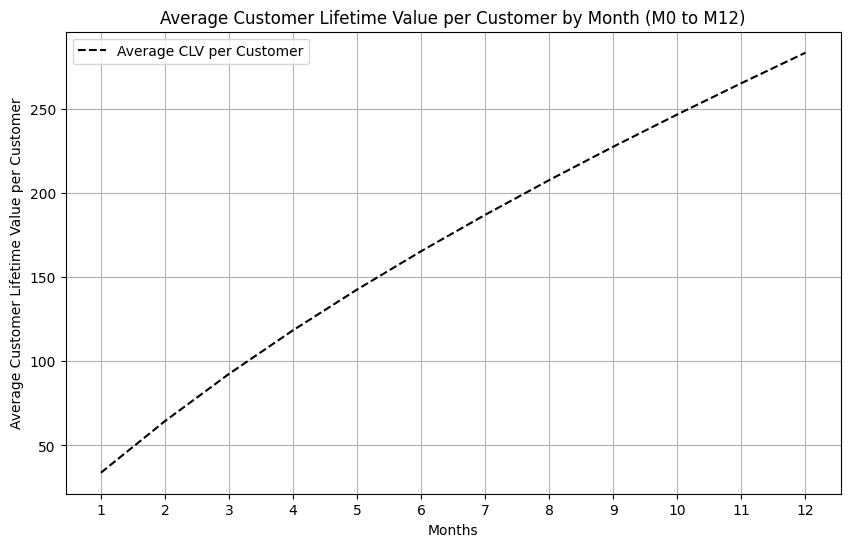

In [10]:
# Calculate the number of customers
num_customers = summary.shape[0]

# Calculate the average CLV per customer for the average row
average_clv_per_customer = pivot_df_12_months.loc['Average'] / num_customers

# Plot the average CLV per customer
plt.figure(figsize=(10, 6))
plt.plot(average_clv_per_customer.index, average_clv_per_customer.values, label='Average CLV per Customer', linestyle='--', color='black')

plt.xlabel('Months')
plt.ylabel('Average Customer Lifetime Value per Customer')
plt.title('Average Customer Lifetime Value per Customer by Month (M0 to M12)')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)
plt.show()